In [2]:
# additional exercise # 4 - (a)
# Log - optimal investment strategy 


import numpy as np
import cvxpy as cp

P = np.array([
    [3.5000, 1.1100, 1.1100, 1.0400, 1.0100],
    [0.5000, 0.9700, 0.9800, 1.0500, 1.0100],
    [0.5000, 0.9900, 0.9900, 0.9900, 1.0100],
    [0.5000, 1.0500, 1.0600, 0.9900, 1.0100],
    [0.5000, 1.1600, 0.9900, 1.0700, 1.0100],
    [0.5000, 0.9900, 0.9900, 1.0600, 1.0100],
    [0.5000, 0.9200, 1.0800, 0.9900, 1.0100],
    [0.5000, 1.1300, 1.1000, 0.9900, 1.0100],
    [0.5000, 0.9300, 0.9500, 1.0400, 1.0100],
    [3.5000, 0.9900, 0.9700, 0.9800, 1.0100]
])
m, n = P.shape

x = cp.Variable(n)
objective = cp.Maximize(cp.geo_mean(P @ x))
constraints = [cp.sum(x) == 1, x >= 0]
prob = cp.Problem(objective, constraints)
prob.solve()

x_opt = x.value
x_unif = np.ones(n) / n

R_opt = np.mean(np.log(P @ x_opt))
R_unif = np.mean(np.log(P @ x_unif))

print("x* =", np.round(x_opt, 4))
print(f"R*_lt = {R_opt:.4f}")
print(f"R_unif = {R_unif:.4f}")

x* = [0.058  0.3999 0.2921 0.25   0.    ]
R*_lt = 0.0231
R_unif = 0.0114


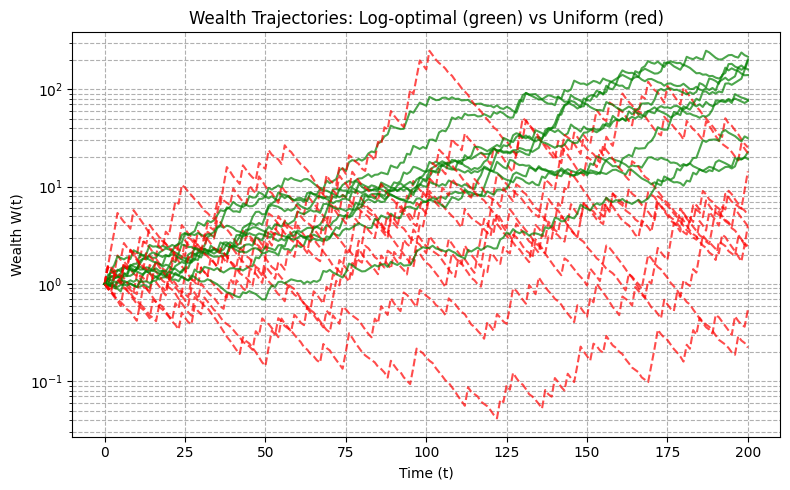

In [3]:
# additional exercise # 4 - (b)
# Log - optimal investment strategy 

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
m = P.shape[0]
N = 10     
T = 200     
W_opt = []
W_unif = []

for i in range(N):
    events = np.random.randint(0, m, size=T)  # 각 시점의 랜덤 시나리오 선택
    P_event = P[events, :]                    # 선택된 시나리오별 수익률
    w_opt_path = np.cumprod(P_event @ x_opt)  # 누적 부 (log-optimal)
    w_unif_path = np.cumprod(P_event @ x_unif)  # 누적 부 (uniform)
    W_opt.append(np.concatenate(([1], w_opt_path)))    # 초기 부 1 포함
    W_unif.append(np.concatenate(([1], w_unif_path)))  # 초기 부 1 포함

# -----------------------------
# Plot results

plt.figure(figsize=(8, 5))
for i in range(N):
    plt.semilogy(W_opt[i], 'g', alpha=0.7)
    plt.semilogy(W_unif[i], 'r--', alpha=0.7)
plt.grid(True, which="both", ls="--")
plt.xlabel("Time (t)")
plt.ylabel("Wealth W(t)")
plt.title("Wealth Trajectories: Log-optimal (green) vs Uniform (red)")
plt.tight_layout()
plt.show()


In [8]:
# Maximizing house profit in a gamble and imputed probabilities.
import numpy as np
import cvxpy as cp

# solution for gambling problem
A = np.array([[1, 0, 1, 0, 0],
              [1, 0, 0, 1, 0],
              [0, 0, 0, 0, 1],
              [0, 1, 1, 0, 0],
              [0, 0, 1, 1, 0]])
p = np.array([0.5, 0.6, 0.6, 0.6, 0.2])
q = np.array([10, 5, 5, 20, 10])
n = 5
m = 5

# cvx_begin
x = cp.Variable(n)
t = cp.Variable()
# dual variable lambda1
constraints = [A @ x <= t,
               x >= 0,
               x <= q]
objective = cp.Maximize(p.T @ x - t)
prob = cp.Problem(objective, constraints)
prob.solve()
# cvx_end

# optimal worst case house profit
pwc = prob.value

# optimal worst case profit if all offer are accepted
pwc_accept = p.T @ q - np.max(A @ q)

# imputed probabilities
lambda1 = constraints[0].dual_value
pi = lambda1

# fair prices
pfair = A.T @ pi

# optimal purchase quantities
xopt = x.value

# Our results are
print("pwc =", pwc)
print("pwc_accept =", pwc_accept)
print("pi =", pi)
print("pfair =", pfair)
print("xopt =", xopt)

pwc = 3.4999999940788555
pwc_accept = -5.0
pi = [0.08899928 0.41100072 0.11154698 0.19945374 0.18899928]
pfair = [0.5        0.19945374 0.47745231 0.6        0.11154698]
xopt = [5.         5.         4.99999999 5.         9.99999999]


U = -33.57725134530702
min_thresh = 0.56


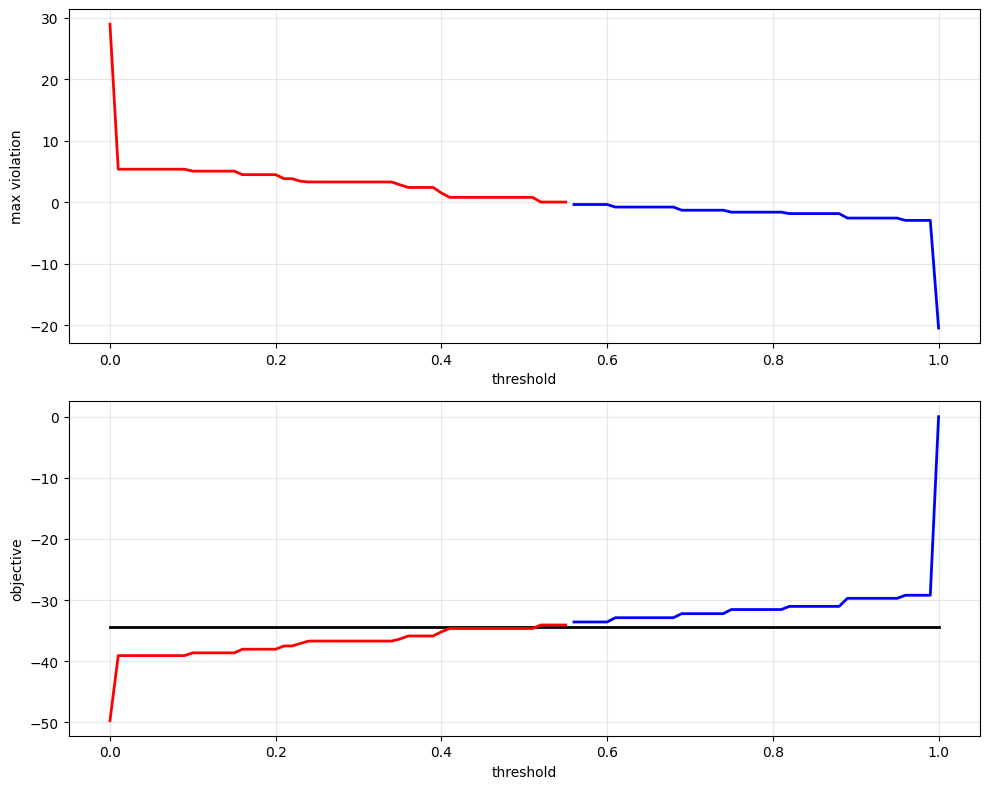

In [9]:
# Heuristic suboptimal solution for BooleanLP

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(0)
n = 100
m = 300
A = np.random.rand(m, n)
b = A @ np.ones(n) / 2
c = -np.random.rand(n)

# solve LP relaxation : Lower Bound, L
# cvx_begin
x = cp.Variable(n)
objective = cp.Minimize(c.T @ x)
constraints = [A @ x <= b,
               x >= 0,
               x <= 1]
prob = cp.Problem(objective, constraints)
prob.solve()
# cvx_end

xrlx = x.value
L = prob.value

# sweep over threshold & round
thres = np.arange(0, 1.01, 0.01)
maxviol = np.zeros(len(thres))
obj = np.zeros(len(thres))

for i in range(len(thres)):
    xhat = (xrlx >= thres[i]).astype(float)
    maxviol[i] = np.max(A @ xhat - b)
    obj[i] = c.T @ xhat

# find least upper bound and associated threshold
i_feas = np.where(maxviol <= 0)[0]
U = np.min(obj[i_feas])
t = np.min(i_feas)
min_thresh = thres[t]

print(f"U = {U}")
print(f"min_thresh = {min_thresh}")

# plot objective and max violation versus threshold
plt.figure(figsize=(10, 8))

# subplot(2,1,1)
plt.subplot(2, 1, 1)
plt.plot(thres[:t], maxviol[:t], 'r', linewidth=2)
plt.plot(thres[t:], maxviol[t:], 'b', linewidth=2)
plt.xlabel('threshold')
plt.ylabel('max violation')
plt.grid(True, alpha=0.3)

# subplot(2,1,2)
plt.subplot(2, 1, 2)
plt.plot(thres, L * np.ones(len(thres)), 'k', linewidth=2)
plt.plot(thres[:t], obj[:t], 'r', linewidth=2)
plt.plot(thres[t:], obj[t:], 'b', linewidth=2)
plt.xlabel('threshold')
plt.ylabel('objective')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
